# Homework 7

# I

## 2.1

首先，容易知道若有平稳解，则$X_t$的期望为0

\begin{cases}
E [X_t X_t] = a E[X_{t-1}, X_t] + E[\epsilon_t X_t] \\
E [X_t X_{t-1}] = a E[X_{t-1}, X_{t-1}] + E[\epsilon_t X_{t-1}]
\end{cases}

也即：
\begin{cases}
\gamma_0 = a \gamma_1 + \sigma^2 \\
\gamma_1 = a \gamma_0
\end{cases}

即：

$$
\gamma_0 = a^2 \gamma_0 + \sigma^2 > \gamma_0 + \sigma^2
$$

显然矛盾。

## 2.4

若$A(z)$的所有零点都在单位圆外，那么由根与系数的关系可以知道：

$$
(-1)^{p+1}\frac{1}{a_p} = \prod_{i=1}^p z_i
$$

也即：

$$
|a_p| = \prod_{i=1}^p \frac{1}{|z_i|} < 1

## 2.5

对于$\epsilon$：

$$
\gamma_0 = Cov(\epsilon_t - 2\epsilon_{t-1}, \epsilon_t - 2\epsilon_{t-1}) = 5 \sigma^2 \\
\gamma_1 = Cov(\epsilon_t - 2\epsilon_{t-1}, \epsilon_{t-1} - 2\epsilon_{t-2}) = -2 \sigma^2 \\
\gamma_n = 0, \forall n > 1
$$

对于$\eta$：

$$
\tilde \gamma_0 = Cov(\eta_t - 0.5\eta_{t-1}, \eta_t - 0.5\eta_{t-1}) = 1.25 \tilde \sigma^2 \\
\tilde \gamma_1 = Cov(\eta_t - 0.5\eta_{t-1}, \eta_{t-1} - 0.5\eta_{t-2}) = -0.5 \tilde \sigma^2 \\
\tilde \gamma_n = 0, \forall n > 1
$$

故令$\tilde \sigma^2 = 4 \sigma^2$即可，即$\eta_t \sim WN(0, 4 \sigma^2)$（正态）

# II

## 5.2

$$
\gamma_3 = -0.1 \gamma_4 + 0.72 \gamma_5 \\
\gamma_2 = -0.1 \gamma_3 + 0.72 \gamma_4 \\
\gamma_1 = -0.1 \gamma_2 + 0.72 \gamma_3 \\
\gamma_0 = -0.1 \gamma_1 + 0.72 \gamma_2 + \sigma^2 \\
\gamma_1 = -0.1 \gamma_0 + 0.72 \gamma_1 \\
\gamma_2 = -0.1 \gamma_1 + 0.72 \gamma_0
$$

In [8]:
!conda rename -p /Users/shuhao.liu/work/.conda tsa


CondaEnvException: Cannot rename the active environment



In [3]:
import numpy as np

A = np.array([
    [0,0,0,100,10,-72],
    [0,0,100,10,-72,0],
    [0,100,10,-72,0,0],
    [100,10,-72,0,0,0],
    [10,28,0,0,0,0],
    [-72,10,100,0,0,0]
])
B = np.array([0,0,0,1,0,0])
cov = np.linalg.solve(A,B)
corr = cov[1:] / cov[0]
print(corr)

[-0.35714286  0.75571429 -0.39107143  0.9952877  -0.40492036]


In [301]:
def AR(a_list, num, sigma=1):
    a_array = np.array(a_list)
    total_num = num + 10000
    epsilon = np.random.normal(0,sigma,total_num)
    X = np.full(total_num, 0.)
    p = len(a_array)
    new_X = np.append(np.zeros(p), X).copy()
    for k in range(total_num):
        new_X[k+p] = np.dot(a_array, new_X[k:k+p][::-1]) + epsilon[k]
    return new_X[-num:]

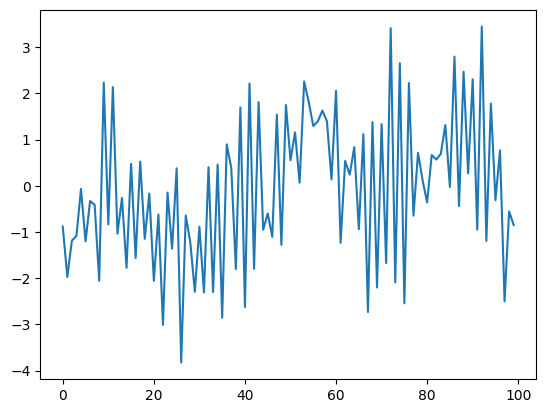

In [302]:
import matplotlib.pyplot as plt
X = AR([-0.1, 0.72], 100)
plt.plot(X)

In [287]:
def order(X, k):
    new_X = np.zeros((len(X),k)).copy()
    for n in range(k):
        new_X[:, n] = np.roll(X, n+1)
        new_X[:n+1, n] = 0
    return new_X.copy(), X.copy()

def PACF(X, k):
    if k == 0:
        return 1
    else:
        new_X, Y = order(X, k)
        A = np.dot(new_X.T, new_X)
        B = np.dot(new_X.T, Y)
        return np.linalg.solve(A, B)[-1]

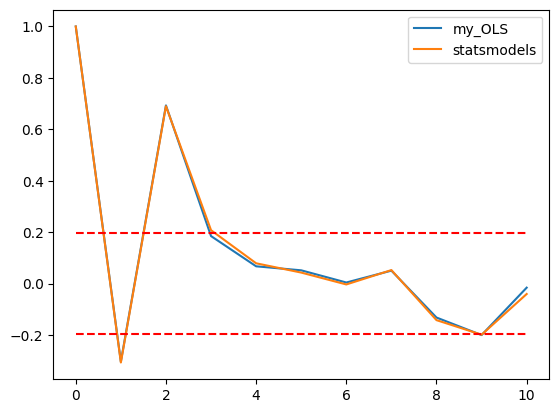

In [308]:
def my_pacf_plot(X, lag=10):
    # 自己算
    pacf = []
    for k in range(lag+1):
        pacf.append(PACF(X, k))

    # 使用statsmodels
    from statsmodels.tsa.stattools import pacf_ols
    pacf_model= pacf_ols(X, nlags=lag, efficient=True, adjusted=False)


    threshold = 1.96/np.sqrt(len(X))
    plt.figure()
    plt.plot(pacf, label='my_OLS')
    plt.plot(pacf_model, label='statsmodels')
    plt.hlines(threshold, 0, 10, colors='r', linestyles='dashed')
    plt.hlines(-threshold, 0, 10, colors='r', linestyles='dashed')
    plt.legend()
    plt.show()
    
my_pacf_plot(X)

In [178]:
def _gamma(X, n):
    x_1 = X; x_2 =  np.append([0] * n, X[:len(X)-n])
    mu = np.mean(X)
    return np.mean((x_1 - mu) * (x_2 - mu))
def _YW_matrix(array):
    n = len(array)
    new_array = np.zeros((n, n))
    for k in range(len(array)):
        new_array += np.diag([array[k]]*(n-k), k)
        if k != 0:
            new_array += np.diag([array[k]]*(n-k), -k)
    return new_array

def Yw(X, k):    
    gamma = np.array([])
    for i in range(k+1):
        gamma = np.append(gamma, _gamma(X, i))
    Gamma = _YW_matrix(gamma[:-1])
    gamma_0 = gamma[1:]
    return np.linalg.solve(Gamma, gamma_0)

def Ols(X, k):
    new_X, Y = order(X, k)
    A = np.dot(new_X.T, new_X)
    B = np.dot(new_X.T, Y)
    return np.linalg.solve(A, B)

def Mle(X, k):
    n = len(X)
    X_array = np.zeros((k, n))
    for m in range(1, k+1):
        X_array[m-1] = np.append([0] * m, X[:-m])
    A = np.dot(X_array, X_array.T)
    B = np.dot(X_array, X.reshape(-1, 1))
    return np.linalg.solve(A, B).flatten()

def R2(X, beta):
    k = len(beta)
    new_X, Y = order(X, k)
    Y_pred = np.dot(new_X, beta.reshape(-1, 1))
    SSR = np.sum((Y_pred - Y)**2)
    SST = np.sum((Y - np.mean(Y))**2)
    return 1 - SSR/SST

def Residual(X, beta):
    k = len(beta)
    new_X, Y = order(X, k)
    Y_pred = np.dot(new_X, beta.reshape(-1, 1))
    return Y - Y_pred.flatten()

In [180]:
from statsmodels.tsa.ar_model import AutoReg

# 在定阶
print("在定阶处（k=2）的Yule_Walker估计R方为：", R2(X, Yw(X, 2)))
print("在定阶处（k=2）的OLS估计R方为：", R2(X, Ols(X, 2)))
print("在定阶处（k=2）的MLE估计R方为：", R2(X, Mle(X, 2)))
print("在定阶处（k=2）的statsmodels调包估计R方为：", R2(X, AutoReg(X, 2, 'n').fit().params))

# 比定阶大一阶
print("比定阶大一阶（k=3）的Yule_Walker估计R方为：", R2(X, Yw(X, 2)))
print("比定阶大一阶（k=3）的OLS估计R方为：", R2(X, Ols(X, 3)))
print("比定阶大一阶（k=3）的MLE估计R方为：", R2(X, Mle(X, 3)))
print("比定阶大一阶（k=3）的statsmodels调包估计R方为：", R2(X, AutoReg(X, 3, 'n').fit().params))

# 比定阶小一阶
print("比定阶小一阶（k=1）的Yule_Walker估计R方为：", R2(X, Yw(X, 2)))
print("比定阶小一阶（k=1）的OLS估计R方为：", R2(X, Ols(X, 1)))
print("比定阶小一阶（k=1）的MLE估计R方为：", R2(X, Mle(X, 1)))
print("比定阶小一阶（k=1）的statsmodels调包估计R方为：", R2(X, AutoReg(X, 1, 'n').fit().params))

在定阶处（k=2）的Yule_Walker估计R方为： -159.51574532545723
在定阶处（k=2）的OLS估计R方为： -167.64074514379337
在定阶处（k=2）的MLE估计R方为： -167.64074514379337
在定阶处（k=2）的statsmodels调包估计R方为： -167.532410357539
比定阶大一阶（k=3）的Yule_Walker估计R方为： -159.51574532545723
比定阶大一阶（k=3）的OLS估计R方为： -167.6608333702891
比定阶大一阶（k=3）的MLE估计R方为： -167.6608333702891
比定阶大一阶（k=3）的statsmodels调包估计R方为： -167.45405858502954
比定阶小一阶（k=1）的Yule_Walker估计R方为： -159.51574532545723
比定阶小一阶（k=1）的OLS估计R方为： -127.07682885895588
比定阶小一阶（k=1）的MLE估计R方为： -127.07682885895588
比定阶小一阶（k=1）的statsmodels调包估计R方为： -127.07682885895588


不妨就用OLS估计：

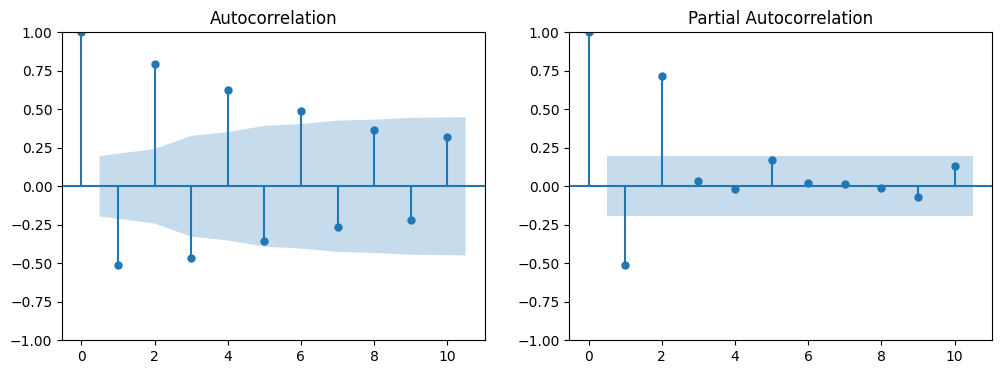

In [219]:
residual = Residual(X, Ols(X, 2))
# acf
def acf_test(residual, lag=10):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    _, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(residual, lags=lag, ax=ax[0])
    plot_pacf(residual, lags=lag, ax=ax[1])
    plt.show()
acf_test(X)

In [229]:
# Box-Pierce检验
def BP_test(residual, lag=10):
    from scipy.stats import chi2
    n = len(residual)
    gamma_noise = np.array([])
    for k in range(1, lag+1):
        gamma_noise = np.append(gamma_noise, _gamma(residual, k))
    Bp = n * np.sum(gamma_noise**2)

    alpha = 0.05
    p = chi2.ppf(1-alpha, lag)

    print("Box-Pierce检验的统计量为：", Bp)
    print("Box-Pierce检验的p值为：", p)
    print("由于统计量小于p值，所以不能拒绝原假设，即残差是白噪声")
BP_test(residual)

Box-Pierce检验的统计量为： 5.19854615331941
Box-Pierce检验的p值为： 18.307038053275146
由于统计量小于p值，所以不能拒绝原假设，即残差是白噪声


In [228]:
# Q* Ljung-Box检验
def QLB_test(residual, lag=10):
    from scipy.stats import chi2
    n = len(residual)
    gamma_noise = np.array([])
    for k in range(1, lag+1):
        gamma_noise = np.append(gamma_noise, _gamma(residual, k))

    alpha = 0.05
    p = chi2.ppf(1-alpha, lag)
    coef = np.array([1/(n-k) for k in range(1, lag+1)])
    QLB = n * (n + 2) * np.sum(coef * gamma_noise**2)

    print("Q* Ljung-Box检验的统计量为：", QLB)
    print("Q* Ljung-Box检验的p值为：", p)
    print("由于统计量小于p值，所以不能拒绝原假设，即残差是白噪声")
QLB_test(residual)

Q* Ljung-Box检验的统计量为： 5.630304199535345
Q* Ljung-Box检验的p值为： 18.307038053275146
由于统计量小于p值，所以不能拒绝原假设，即残差是白噪声


# III

In [230]:
x = X[50:60]

small_ols_estimator = Ols(x, 2)
total_ols_estimator = Ols(X, 2)
print("小样本OLS估计的系数为：", small_ols_estimator)
print("大样本OLS估计的系数为：", total_ols_estimator)

小样本OLS估计的系数为： [0.00446328 0.9890275 ]
大样本OLS估计的系数为： [-0.13115345  0.78046175]


可以看到，小样本上系数差了非常多。

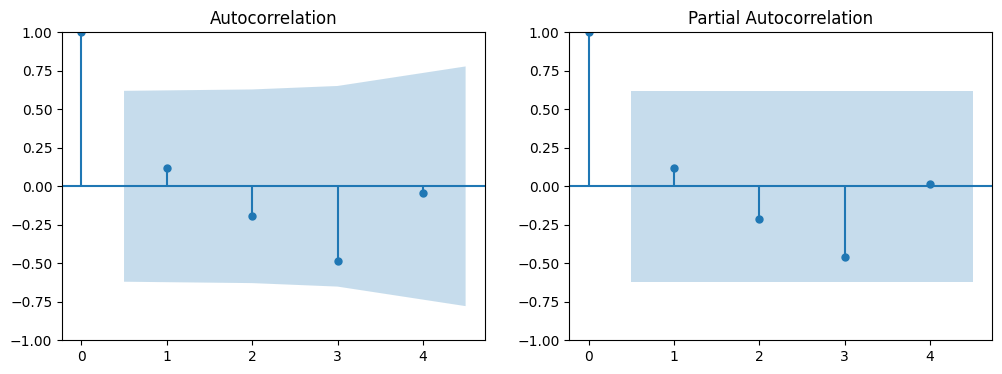

Box-Pierce检验的统计量为： 2.417279997420011
Box-Pierce检验的p值为： 9.487729036781154
由于统计量小于p值，所以不能拒绝原假设，即残差是白噪声
Q* Ljung-Box检验的统计量为： 4.051960965462512
Q* Ljung-Box检验的p值为： 9.487729036781154
由于统计量小于p值，所以不能拒绝原假设，即残差是白噪声


In [233]:
# 白噪声检验
small_residual = Residual(x, small_ols_estimator)
acf_test(small_residual, 4)
BP_test(small_residual, 4)
QLB_test(small_residual, 4)


但仍然通过了白噪声检验。

# IV

特征根方程为：

$$
1 - \frac{3}{4}z + \frac{1}{2}z^2 = 0 \\
2z^2 - 3z + 4 = 0 \\
$$

该二次函数无实根，故该过程是平稳的。



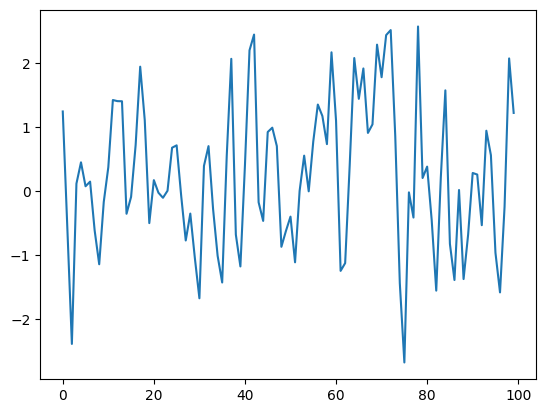

In [313]:
X = AR([0.75, -0.5], 100, sigma=1)
plt.plot(X)

有一定周期性。